In [1]:
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pot_NFW = potential.NFWPotential(m=1e12,r_s=20.0,units=usys)

In [3]:
pot_NFW.potential(jnp.array([1.0,2.0,3.0]),0.0)

Array(-0.20618832, dtype=float64)

In [4]:
ts = jnp.linspace(0,3000,1500)
w0=jnp.array([20.,0.,20.,.0,.2,.0])
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=True )



In [5]:
hamiltonian_field = fields.hamiltonian_field(pot_NFW)
hamiltonian_field.term(0.0,jnp.array([1.,2.,3.,.2,.3,.4]), None)

Array([ 0.2       ,  0.3       ,  0.4       , -0.00119364, -0.00238729,
       -0.00358093], dtype=float64)

In [6]:
kwargs = {'rtol':1e-6,'atol':1e-6,}


In [7]:
field_orb = fields.integrate_field(w0=w0, ts=ts,field=hamiltonian_field, backwards_int=False)
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=False , **kwargs)


sol2 = pot_NFW.integrate_orbit(w0=w0+.01, ts=ts,dense=False , **kwargs)


In [8]:
field_orb.ys

Array([[ 2.00000000e+01,  0.00000000e+00,  2.00000000e+01,
         0.00000000e+00,  2.00000000e-01,  0.00000000e+00],
       [ 1.99976463e+01,  4.00251143e-01,  1.99976463e+01,
        -2.35209715e-03,  1.99976463e-01, -2.35209715e-03],
       [ 1.99905856e+01,  8.00408074e-01,  1.99905856e+01,
        -4.70379249e-03,  1.99905852e-01, -4.70379249e-03],
       ...,
       [ 1.56607953e+01, -1.47378265e+01,  1.56607953e+01,
         9.66770399e-02,  1.64435472e-01,  9.66770399e-02],
       [ 1.58522105e+01, -1.44068126e+01,  1.58522105e+01,
         9.46075566e-02,  1.66349439e-01,  9.46075566e-02],
       [ 1.60394656e+01, -1.40720177e+01,  1.60394656e+01,
         9.25196581e-02,  1.68213921e-01,  9.25196581e-02]],      dtype=float64)

In [9]:
sol.ys.sum()

Array(-1419.8182814, dtype=float64)

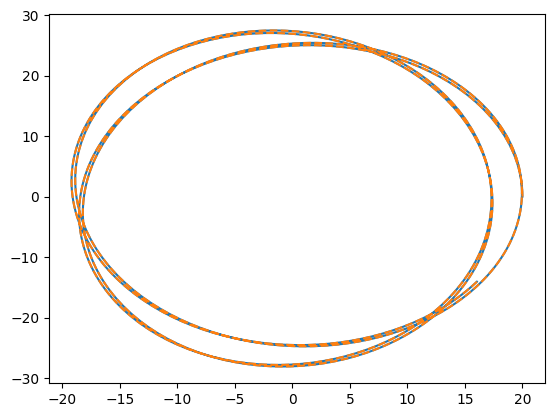

In [10]:
plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [11]:
kwargs = {'rtol':1e-8}


ts.shape

(1500,)

In [ ]:
l, t = pot_NFW.gen_stream_scan(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493) 

In [ ]:
lv, tv = pot_NFW.gen_stream_vmapped(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, **kwargs)

In [ ]:
lv.shape

(1499, 6)

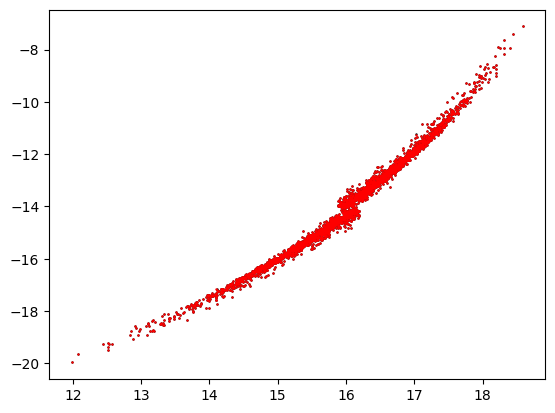

In [ ]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

#plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

plt.scatter(lv[:,0], lv[:,1],s=0.5,color='r')
plt.scatter(tv[:,0], tv[:,1],s=0.5,color='r')

In [ ]:
kwargs = {'rtol':1e-5, 'atol':1e-5}

In [ ]:
diffrax.Tsit5(scan_kind="bounded")

Tsit5(scan_kind='bounded')

In [11]:
ld_td = pot_NFW.gen_stream_scan_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, solver=diffrax.Bosh3(scan_kind="bounded"), **kwargs)

In [12]:
ld_td

Solution(
  t0=f64[1499,2],
  t1=f64[1499,2],
  ts=None,
  ys=None,
  interpolation=DenseInterpolation(
    ts=f64[1499,2,10001],
    ts_size=i64[1499,2],
    infos={
      'k':
      f64[1499,2,10000,4,6],
      'y0':
      f64[1499,2,10000,6],
      'y1':
      f64[1499,2,10000,6]
    },
    interpolation_cls=<bound method ThirdOrderHermitePolynomialInterpolation.from_k of <class 'diffrax._local_interpolation.ThirdOrderHermitePolynomialInterpolation'>>,
    direction=i64[1499,2],
    t0_if_trivial=f64[1499,2],
    y0_if_trivial=f64[1499,2,6]
  ),
  stats={
    'max_steps':
    i64[1499,2],
    'num_accepted_steps':
    i64[1499,2],
    'num_rejected_steps':
    i64[1499,2],
    'num_steps':
    i64[1499,2]
  },
  result=EnumerationItem(
    _value=i32[1499,2],
    _enumeration=<class 'diffrax._solution.RESULTS'>
  ),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)

In [13]:
ld, td = StreamSculptor.eval_dense_stream(2000.0, ld_td)

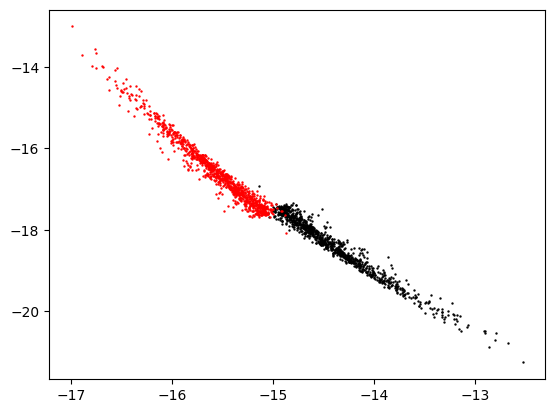

In [14]:
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')


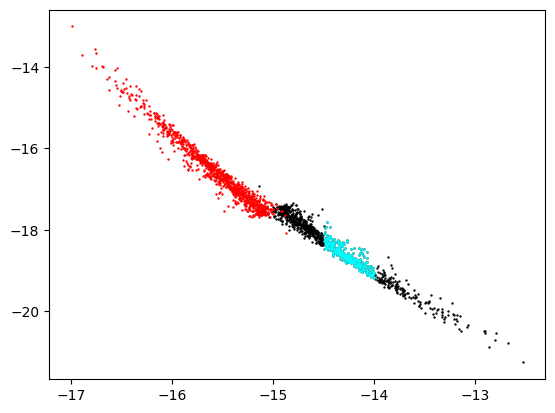

In [15]:
in_bool = (ld[:,0]>-14.5) & (ld[:,0]<-14.0)
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')

plt.scatter(ld[in_bool,0], ld[in_bool,1],s=0.5,color='cyan')

x0v0_SH = jnp.mean(ld[in_bool,:],axis=0)

In [16]:
x0v0_SH.shape

(6,)

In [ ]:
ldv_tdv = pot_NFW.gen_stream_vmapped_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493,solver=diffrax.Bosh3(scan_kind='bounded'), **kwargs)

In [ ]:
ldv, tdv = StreamSculptor.eval_dense_stream(500.0, ldv_tdv)


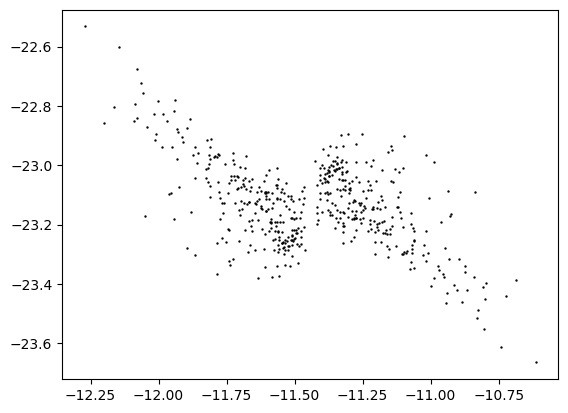

In [ ]:
plt.scatter(ldv[:,0], ldv[:,1],s=0.5,color='k')
plt.scatter(tdv[:,0], tdv[:,1],s=0.5,color='k')


In [17]:
from perturbative import GenerateMassRadiusPerturbation, BaseStreamModel

In [41]:
## Subhalo potential
np.random.seed(3022)
N = 10
M = jnp.ones(N)
a = jnp.ones(N)*.1
subhalo_x0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))

subhalo_x0 = subhalo_x0.at[0].set(x0v0_SH[:3])
subhalo_v = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))
subhalo_v = subhalo_v.at[0].set(x0v0_SH[3:] + jnp.array([0.05,0.001,.0]))

subhalo_t0 = jnp.ones(N)*0.0
subhalo_t0 = subhalo_t0.at[0].set(2000.0)
t_window = jnp.ones(N)*250.0

pot_SH = potential.SubhaloLinePotential(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)
pot_structural = potential.SubhaloLinePotential_dRadius(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)

pot_structural.potential(jnp.array([1.,2,3.]),0.0)


Array(1.09194535e-13, dtype=float64)

In [42]:
pot_SH.potential_per_SH(jnp.array([2,3,4.]),0.0)

Array([ 0.00000000e+00, -1.14377491e-12, -9.08130865e-13, -8.34847535e-13,
       -5.13730197e-13, -9.82111497e-13, -8.38401484e-13, -7.11820571e-13,
       -9.54959727e-13, -8.05331305e-13], dtype=float64)

In [43]:
base_model = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, 
solver=diffrax.Dopri5(scan_kind='bounded') )

In [44]:
pert_Gen = GenerateMassRadiusPerturbation(potential_base=pot_NFW,potential_perturbation=pot_SH,
potential_structural=pot_structural, units=usys,BaseStreamModel=base_model,solver=diffrax.Dopri8(scan_kind='bounded'))

In [45]:
pert_Gen.prog_fieldICs.shape

(1500, 10, 12)

In [46]:
lead_out_and_derivs, trail_out_and_derivs = pert_Gen.compute_perturbation_OTF(cpu=True)

In [25]:
lead_out_and_derivs_v, trail_out_and_derivs_v = pert_Gen.compute_perturbation_OTF(cpu=False)

NameError: name 'lead_out_and_derivs_v' is not defined

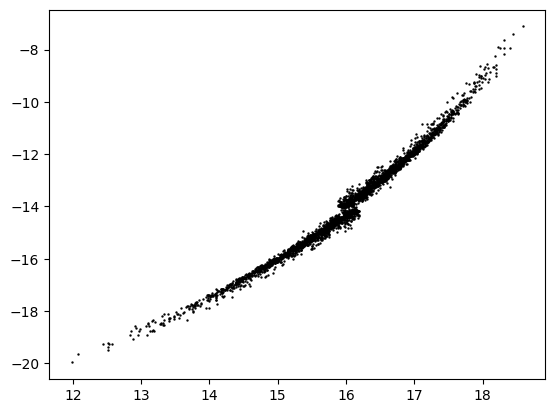

In [26]:
plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(lead_out_and_derivs_v[0][:,0], lead_out_and_derivs_v[0][:,1],s=0.5,color='r')
plt.scatter(trail_out_and_derivs_v[0][:,0], trail_out_and_derivs_v[0][:,1],s=0.5,color='r')

In [47]:
lead_out_and_derivs[1][:,0,:6]

Array([[ 1.67526227e-07,  4.13559168e-07,  1.69191161e-07,
        -2.29868758e-09,  1.88116744e-09, -2.41556389e-09],
       [ 2.27592071e-07,  6.68727361e-07,  2.13699287e-07,
        -3.89465665e-09,  2.00350079e-09, -3.94556947e-09],
       [ 1.87857263e-07,  6.40913801e-07,  1.80973431e-07,
        -3.74735519e-09,  1.66158543e-09, -3.76735435e-09],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

(-21.0, -7.0)

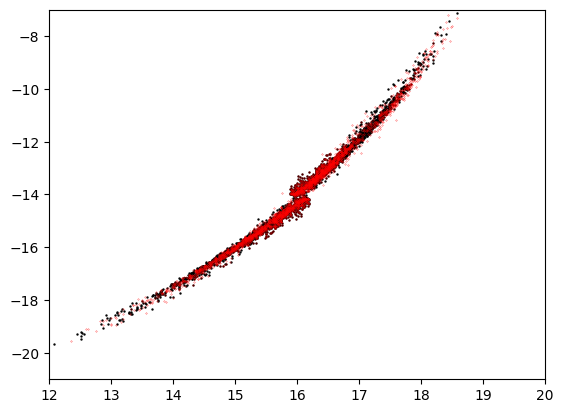

In [48]:

M_sh = 1e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs[1][:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs[1][:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')
#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

In [28]:
stream_lin.shape

(2998, 6)

In [31]:
lead_out_and_derivs[1]/lead_out_and_derivs_v[1]




Array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [28]:
output[0].ys[0].shape#.ys[1].shape

(1499, 2, 6)

In [35]:
output[0].ys[1].shape

(1499, 2, 10, 12)

In [20]:
pert_Gen.compute_perturbation_ICs()[1].shape

(1500, 10, 12)

In [38]:
pert_Gen.perturbation_ICs[1].shape

(1500, 10, 12)

In [31]:
base_model.streamICs[3].shape

(1500, 3)

In [33]:
 jnp.hstack([base_model.streamICs[0], base_model.streamICs[2]]).shape

(1500, 6)

In [22]:
lout, tout = pert_Gen.compute_base_stream(cpu=False)


In [29]:
base_model.dRel_dIC.shape

(1500, 2, 6, 6)

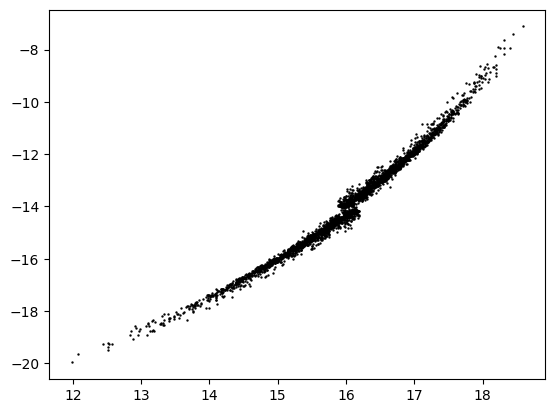

In [23]:
plt.scatter(lout[:,0], lout[:,1],s=0.5,color='k')
plt.scatter(tout[:,0], tout[:,1],s=0.5,color='k')


In [19]:
pert_Gen.fieldICs.ys[1]

(1500, 10, 12)

In [20]:
ts.shape

(1500,)

In [30]:
jnp.sum(pert_Gen.fieldICs.ys[1],axis=1)[2]

Array([-1.35768480e-13,  4.49920989e-15, -1.35768149e-13, -3.87432793e-14,
        1.29758755e-15, -3.87550906e-14,  5.01245915e-16, -1.72591489e-17,
        4.99398722e-16,  1.42980983e-16, -4.97669531e-18,  1.42482560e-16],      dtype=float64)

In [31]:
pert_Gen.jump_ts

Array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float64)

In [ ]:
pot_SH.subhalo_x0.shape

(10, 3)

In [ ]:
pert_Gen.prog_w0

AttributeError: 'GenerateMassRadiusPerturbation' object has no attribute 'prog_w0'

In [ ]:
pert_field = fields.MassRadiusPerturbation_OTF(pert_Gen)



In [ ]:
example_coords = [jnp.hstack([jnp.ones(3),jnp.ones(3)]), 
                jnp.hstack([jnp.ones((10,3)),jnp.ones((10,3)), jnp.ones((10,3)), jnp.ones((10,3))])]
#example_coords[1].shape
pert_field.term(0.0,example_coords, None)

[Array([ 1.        ,  1.        ,  1.        , -0.00290453, -0.00290453,
        -0.00290453], dtype=float64),
 Array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774549e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774549e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774549e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [

In [ ]:
jnp.ones((10,3))

Array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float64)

In [ ]:
pert_Gen.gradientPotentialPerturbation_per_SH(jnp.array([1.,20.,3.]),0.0).shape

(10, 3)

In [ ]:
obj = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, solver=diffrax.Dopri5(scan_kind='bounded') )

In [ ]:
obj.prog_loc_fwd.shape

(1500, 6)

In [ ]:
obj.dRel_dIC

Array([[[[ 9.96418614e-01,  4.87120170e-04, -4.42824880e-05,
          -9.30743752e-02,  1.31131449e-01, -2.19712970e-02],
         [ 1.03703439e-03,  9.96216989e-01,  1.02067057e-04,
           4.18392106e-02,  8.93746158e-02, -1.20250323e-01],
         [ 1.34265400e-03,  8.89893678e-04,  9.96105638e-01,
          -6.74033188e-02,  7.26106414e-02,  3.69975941e-03],
         [ 6.32656012e-06, -4.10394642e-07, -7.62879260e-07,
           1.00013673e+00, -4.93138630e-04,  2.95917439e-04],
         [ 3.56197289e-06, -1.90869969e-06, -3.86061491e-06,
           5.61375084e-04,  1.00018700e+00, -7.25433287e-04],
         [ 2.54819675e-06, -2.46533325e-06, -3.85776049e-06,
          -6.29240028e-04,  3.29080427e-04,  1.00034053e+00]],

        [[ 1.00358139e+00, -4.87120170e-04,  4.42824880e-05,
           9.30743752e-02, -1.31131449e-01,  2.19712970e-02],
         [-1.03703439e-03,  1.00378301e+00, -1.02067057e-04,
          -4.18392106e-02, -8.93746158e-02,  1.20250323e-01],
         [-1.3

In [ ]:
deriv = obj.release_func_jacobian()

In [ ]:
deriv.shape

(1500, 2, 6, 6)

In [ ]:
from genstream import StreamModel
